# グラフオートエンコーダで企業家ネットワークの埋め込みを求める
https://github.com/pyg-team/pytorch_geometric/blob/master/examples/autoencoder.py

In [1]:
# データの読み込み
import networkx as nx

graphml_file = 'data/kanagawa_kigyou.graphml'

# GraphMLファイルの読み込み
G = nx.read_graphml(graphml_file)

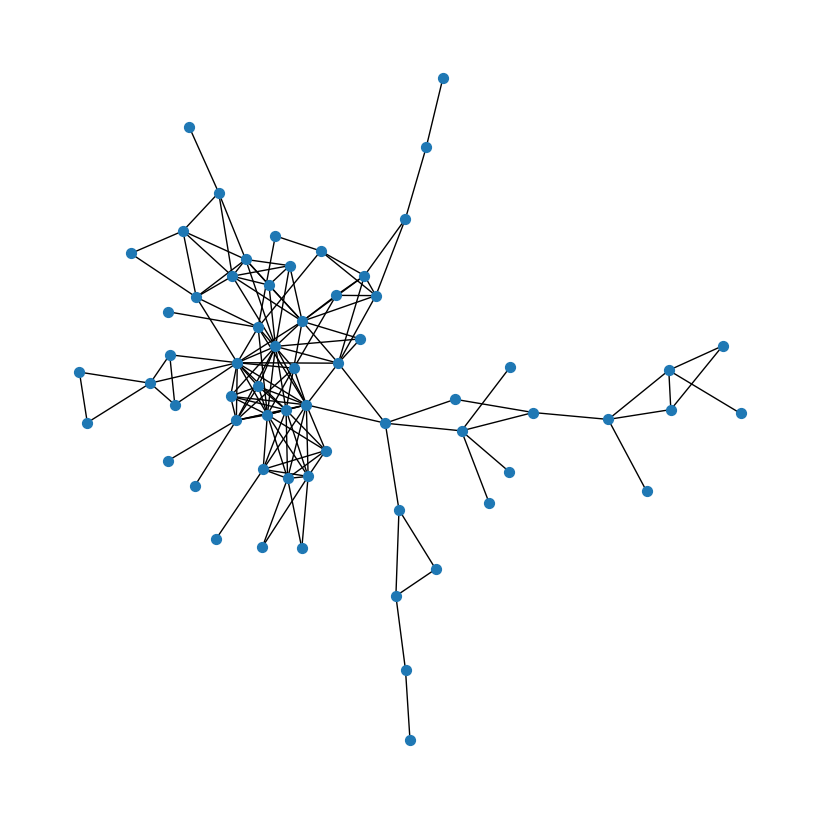

In [10]:
# 可視化
# graphvizバージョン
import matplotlib.pyplot as plt

# 最大連結成分のみ
largest_cc = max(nx.connected_components(G), key=len)
G_draw = G.subgraph(largest_cc)

# ノード名を数字に変換
# graphvizは旧字体があるとエラーが出る
node_mapping = {node: i for i, node in enumerate(G_draw.nodes())}
G_draw = nx.relabel_nodes(G_draw, node_mapping)

# グラフ描画
pos = nx.nx_pydot.graphviz_layout(G_draw)
plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw, pos=pos, with_labels=False, font_family="MS Gothic", node_size=50, font_size=9)
plt.show()

In [2]:
# 最大連結成分だけ使う
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc)

In [3]:
# ノードの特徴量
import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler

node_attributes = nx.get_node_attributes(G, '資本金')
x = [[node_attributes[node]] for node in G.nodes()]

# 正規化
scaler = StandardScaler()
scaler = MinMaxScaler()

x = torch.log1p(torch.tensor(x))
x_scaled = scaler.fit_transform(x)

x = torch.tensor(x_scaled, dtype=torch.float32)

# # ノード属性がない場合、単位行列を使う
# num_nodes = G.number_of_nodes()
# x = torch.eye(num_nodes)

x

tensor([[0.5410],
        [0.8423],
        [0.3792],
        [0.4200],
        [0.1477],
        [0.6291],
        [0.3792],
        [0.5186],
        [0.5410],
        [0.6641],
        [0.3209],
        [0.6002],
        [0.1924],
        [0.3792],
        [0.3792],
        [0.6804],
        [0.5186],
        [0.7909],
        [0.3792],
        [0.5883],
        [0.4489],
        [0.4489],
        [0.3095],
        [0.3568],
        [0.3792],
        [0.5883],
        [0.6804],
        [0.0556],
        [0.6804],
        [0.5186],
        [0.5410],
        [0.5186],
        [0.5883],
        [0.3279],
        [0.3279],
        [0.5594],
        [0.9120],
        [0.4489],
        [0.7212],
        [0.4897],
        [0.4897],
        [0.7501],
        [0.3568],
        [0.6107],
        [0.3976],
        [0.1253],
        [0.3792],
        [0.0000],
        [0.4897],
        [1.0000],
        [0.4489],
        [0.3976],
        [0.3792],
        [0.3279],
        [0.6291],
        [0

In [316]:
# PyG (PyTorch Geometric)で使える形式に変換

from torch_geometric.data import Data

# ノードに数値IDを割り当てる（日本語を数値に変換）
mapping = {node: i for i, node in enumerate(G.nodes())}
G_num = nx.relabel_nodes(G, mapping)

# PyGはエッジリストを (2, num_edges) 形式で要求するため、エッジを転置
edge_index = torch.tensor(list(G_num.edges), dtype=torch.long).t().contiguous()

# PyGのデータ形式に変換
data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[63, 1], edge_index=[2, 149])


In [317]:
# 前処理
# autoencoder_sample.ipynb参照
import torch_geometric.transforms as T

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform = T.Compose([
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
    split_labels=True, add_negative_train_samples=False),
])

train_data, val_data, test_data = transform(data)

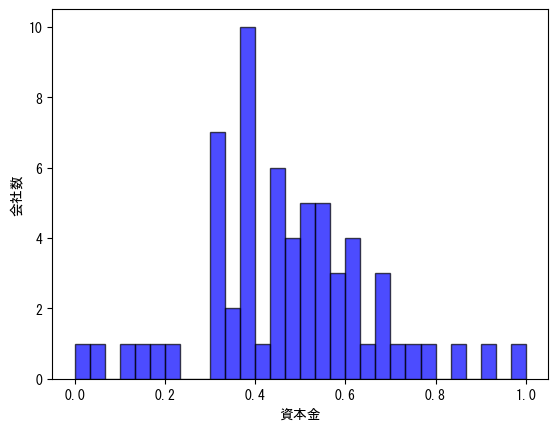

In [318]:
# 特徴量の分布を確認

feature = train_data.x.cpu().numpy().flatten()
# feature = x.numpy().flatten()

# ヒストグラムを描画
plt.hist(feature, bins=30, alpha=0.7, color='b', edgecolor='black')

plt.xlabel('資本金', fontdict={'family': 'MS Gothic'})
plt.ylabel('会社数', fontdict={'family': 'MS Gothic'})
plt.show()

In [364]:
# モデルの定義
from torch_geometric.nn import GAE, GCNConv

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    

# in_channels: 特徴量の次元数
# out_channels: 埋め込みの次元数
in_channels, out_channels = data.num_features, 2
model = GAE(GCNEncoder(in_channels, out_channels))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [365]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index)

    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

Epoch: 001, AUC: 0.8010, AP: 0.8594
Epoch: 002, AUC: 0.8061, AP: 0.8614
Epoch: 003, AUC: 0.8061, AP: 0.8614
Epoch: 004, AUC: 0.8112, AP: 0.8640
Epoch: 005, AUC: 0.8163, AP: 0.8656
Epoch: 006, AUC: 0.8163, AP: 0.8595
Epoch: 007, AUC: 0.8214, AP: 0.8624
Epoch: 008, AUC: 0.8265, AP: 0.8646
Epoch: 009, AUC: 0.8367, AP: 0.8701
Epoch: 010, AUC: 0.8367, AP: 0.8701
Epoch: 011, AUC: 0.8367, AP: 0.8701
Epoch: 012, AUC: 0.8367, AP: 0.8701
Epoch: 013, AUC: 0.8316, AP: 0.8643
Epoch: 014, AUC: 0.8316, AP: 0.8643
Epoch: 015, AUC: 0.8316, AP: 0.8643
Epoch: 016, AUC: 0.8316, AP: 0.8643
Epoch: 017, AUC: 0.8316, AP: 0.8643
Epoch: 018, AUC: 0.8367, AP: 0.8701
Epoch: 019, AUC: 0.8367, AP: 0.8701
Epoch: 020, AUC: 0.8367, AP: 0.8701
Epoch: 021, AUC: 0.8367, AP: 0.8701
Epoch: 022, AUC: 0.8367, AP: 0.8701
Epoch: 023, AUC: 0.8316, AP: 0.8679
Epoch: 024, AUC: 0.8265, AP: 0.8661
Epoch: 025, AUC: 0.8265, AP: 0.8661
Epoch: 026, AUC: 0.8265, AP: 0.8661
Epoch: 027, AUC: 0.8265, AP: 0.8661
Epoch: 028, AUC: 0.8265, AP:

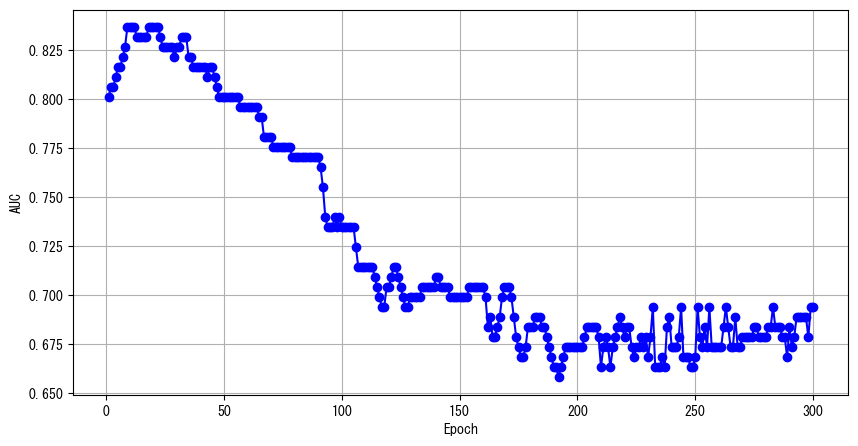

In [366]:
# 学習
import matplotlib.pyplot as plt

epochs = 300
auc_history = []
best_auc = 0
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(test_data)
    auc_history.append(auc)
    print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')

    # 一番いいモデルを保存する
    if auc > best_auc:
        best_auc = auc
        best_model_state = model.state_dict()  # モデルのパラメータを保存

# AUCの変化の可視化
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), auc_history, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

## 検証

### 埋め込みの可視化

In [367]:
# 一番いいモデルをロード
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [368]:
model.eval()
z = model.encode(train_data.x, train_data.edge_index)
with torch.no_grad():
    z = z.cpu().numpy()
z.shape

(63, 2)

In [350]:
# 描画する関数
def plot_points(z, node_labels=None):
    """
        z: 埋め込み
        node_labels: G.nodesを指定すればOK 何も指定しなければラベルを表示しない
    """

    plt.figure(figsize=(9, 9))
    plt.scatter(z[:, 0], z[:, 1], s=70, color='b', alpha=0.6)

    # ノードのラベルを表示
    if node_labels:
        for i, label in enumerate(node_labels):
            plt.text(z[i, 0], z[i, 1] + 0.08, label, fontsize=9, ha='center', va='center', fontname="MS Gothic")

    plt.axis('off')
    plt.show()

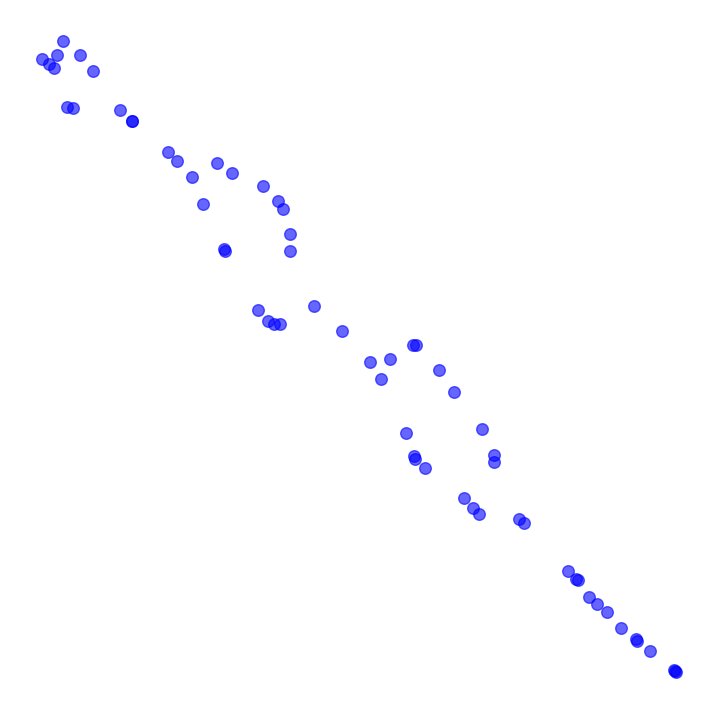

In [374]:
# TSNEを使うパターン
from sklearn.manifold import TSNE

z_transformed = TSNE(n_components=2).fit_transform(z)
plot_points(z_transformed)

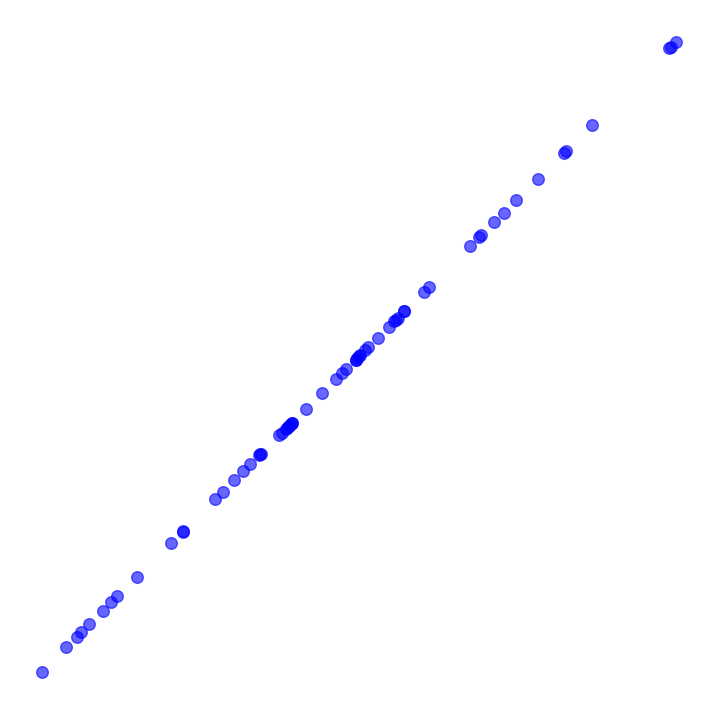

In [372]:
# 2次元の埋め込み
plot_points(z)

### クラスタリング 

In [401]:
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(z)

KMeans(n_clusters=5, random_state=42)

In [4]:
# クラスタリングを可視化

def plot_clustering(z, cluster_labels, n_clusters, cmap):
    plt.figure(figsize=(8, 8))
    for i in range(n_clusters):
        plt.scatter(z[cluster_labels == i, 0], z[cluster_labels == i, 1], s=20, color=cmap(i), label=f'Cluster {i}')
    plt.axis('off')
    plt.legend(title='Clusters')
    plt.show()

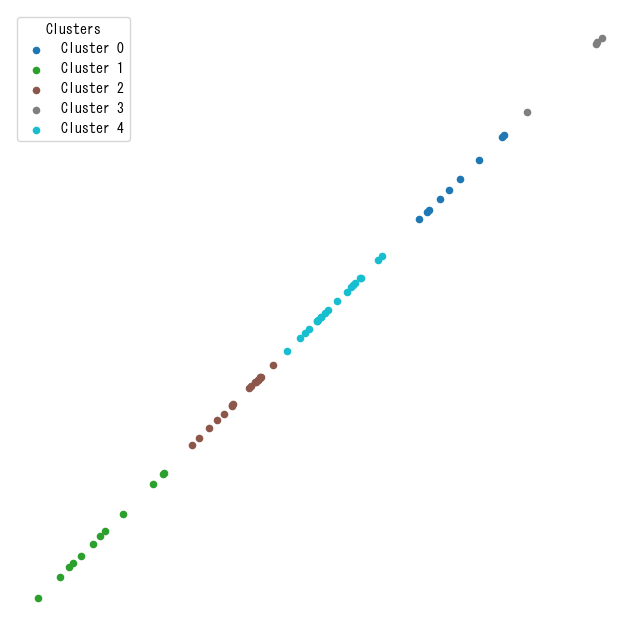

In [402]:
# カラーマップを取得
cmap = plt.get_cmap('tab10', n_clusters)

plot_clustering(z, kmeans.labels_, n_clusters, cmap)
# plot_clustering(z, kmeans.labels_, n_clusters, cmap)

In [7]:
# ノード名を数字に変換
# graphvizは旧字体があるとエラーが出る
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G_draw = nx.relabel_nodes(G, node_mapping)

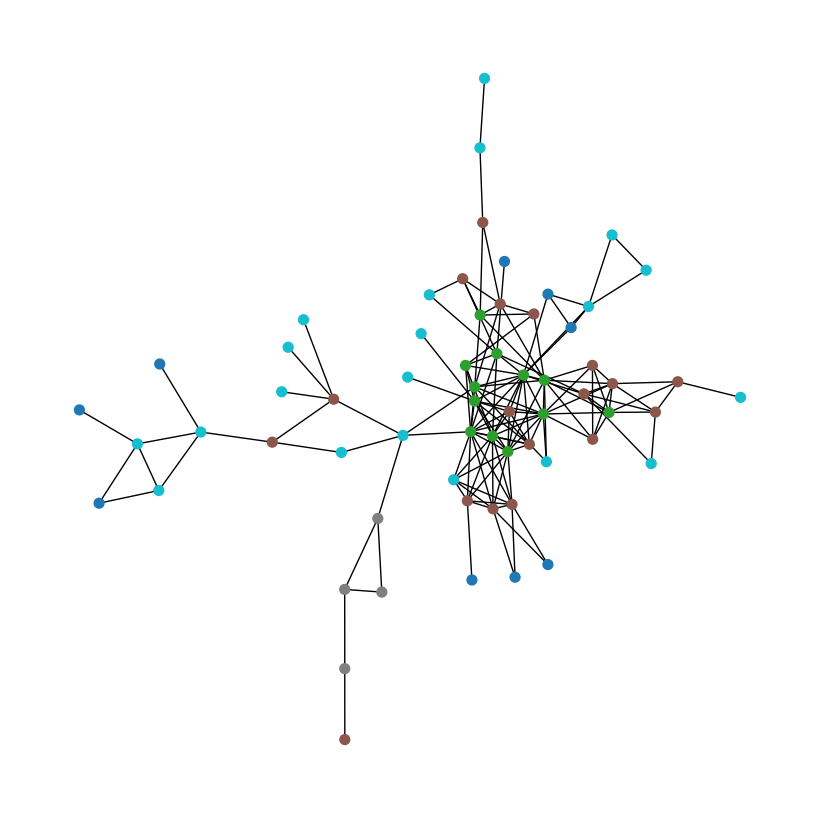

In [403]:
# ネットワークでクラスタリングを可視化
# graphvizバージョン

# G_draw = G

np.random.seed(42)
plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw,
        pos=nx.nx_pydot.graphviz_layout(G_draw),
        node_size=50,
		cmap=cmap,
		node_color=kmeans.labels_
		)
plt.show()

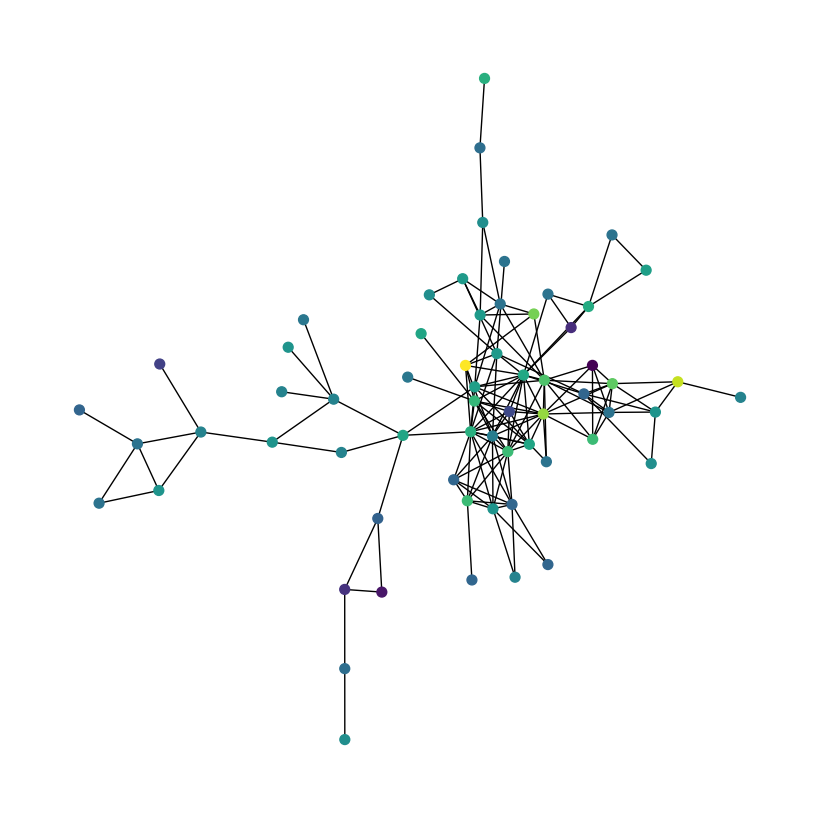

In [361]:
# 属性を可視化
cmap = plt.get_cmap("viridis")

colors = [cmap(value) for value in x]

# ノード名を数字に変換
# graphvizは旧字体があるとエラーが出る
node_mapping = {node: i for i, node in enumerate(G_draw.nodes())}
G_draw = nx.relabel_nodes(G_draw, node_mapping)

np.random.seed(42)  # シード値を固定化
plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw,
        pos=nx.nx_pydot.graphviz_layout(G_draw),
        node_size=50,
		node_color=colors
		)

### Louvain法でクラスタリング

In [127]:
import community as community_louvain

# Louvain法によるクラスタリング
partition = community_louvain.best_partition(G)

partition

{'株式會社横濱商業銀行': 0,
 '株式會社横濱七十四銀行': 1,
 '株式會社横濱實業銀行': 0,
 '株式會社横濱中央銀行': 2,
 '神奈川電燈株式會社': 5,
 '太陽合資會社': 5,
 '株式會社横濱貿易銀行': 0,
 '株式會社厚木銀行': 4,
 '株式會社藤澤銀行': 5,
 '株式會社横濱蠶絲銀行': 2,
 '原合名會社': 1,
 '株式會社武相貯蓄銀行': 5,
 '株式會社横濱銀行': 2,
 '相模觀業株式會社': 5,
 '太平石油合名會社': 1,
 '京濱電氣鐡道株式會社': 2,
 '日本薄荷株式會社': 0,
 '株式會社左右田貯蓄銀行': 3,
 '株式會社神奈川縣農工銀行': 5,
 '横濱運搬株式會社': 3,
 '株式會社横濱貯蓄銀行': 1,
 '厚木倉庫株式會社': 4,
 '三忠合名會會社': 2,
 '合名會社横濱若尾銀行': 2,
 '中央倉庫株式會社': 0,
 '合名會社茂木商店': 1,
 '日本絹綿紡績株式會社': 3,
 'イントル_ナショナル_ヲイル_コムパニー(株式)': 1,
 '株式會社相模銀行': 5,
 '相模馬車株式會社': 4,
 '横濱硝子合資會社': 2,
 '株式會社横濱貿易倉庫': 0,
 '横須賀商業合資會社': 5,
 '株式會社横濱米穀株式取引所': 0,
 '合名會社茂木銀行': 1,
 '横濱火災運送保險株式會社': 1,
 '株式會社横濱實業貯蓄銀行': 0,
 '株式會社伊勢原銀行': 5,
 '横濱電線製造株式會社': 2,
 '株式會社武藏商業銀行': 1,
 '株式會社横濱中央貯蓄銀行': 2,
 '株式會社浦賀銀行': 5,
 '合資會社誠資銀行': 2,
 '株式會社大師銀行': 2,
 '横濱共同電燈株式會社': 2,
 '半原糸繭市塲株式會社': 4,
 '横濱硝子製造株式會社': 0,
 '株式會社金叶貯蓄銀行': 2,
 '水車株式會社': 5,
 '日本製茶株式會社': 1,
 '直輸製絲盛進合資會社': 2,
 '東京麥酒株式會社': 2,
 '横濱正金銀行': 2,
 '株式會社吾妻銀行': 5,
 '株式會社横濱蠶絲外四品取引所': 2,
 '株式會社藤澤貯蓄銀行': 5,
 '株式會社武藏貯蓄銀行': 1,
 '横濱船渠

In [128]:
# Louvain法のクラスタ数を求める
max_key = max(partition, key=lambda x: partition[x])
partition[max_key] + 1

6

In [ ]:
# 結果を描画
# カラーマップはここを参照 https://pygraph.helve-blog.com/matplotlib-conf/colormap

# G_draw = G

plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw,
        pos=nx.nx_pydot.graphviz_layout(G_draw),
        with_labels=False,
        font_family="MS Gothic",
        node_size=50,
        font_size=9,
		cmap=plt.get_cmap('Set1'),
		node_color=[partition[node] for node in G.nodes()]
		)
plt.show()

### 特徴量単位でクラスタリング

In [19]:
from sklearn.cluster import KMeans

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(x)

KMeans(n_clusters=3, random_state=42)

In [11]:
# カラーマップを取得
cmap = plt.get_cmap('tab10', n_clusters)

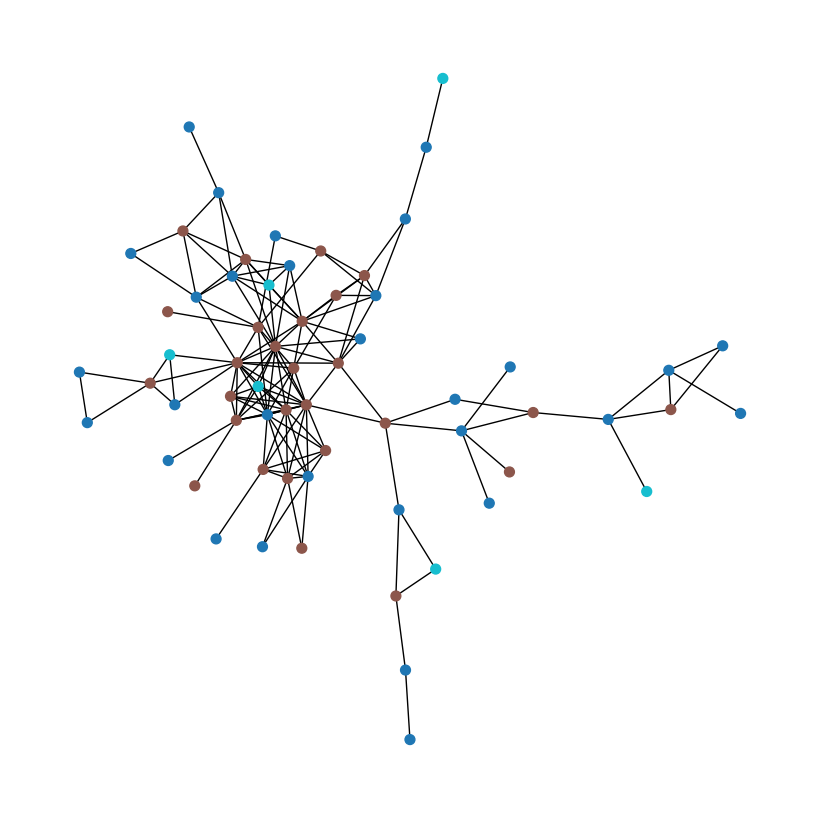

In [20]:
# ネットワークでクラスタリングを可視化
import numpy as np

np.random.seed(42)
plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G_draw,
        pos=nx.nx_pydot.graphviz_layout(G_draw),
        node_size=50,
		cmap=cmap,
		node_color=kmeans.labels_
		)
plt.show()